In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [3]:
pd.set_option('display.max_columns', 50)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [4]:
draft2_path = '/Users/tomerchoresh/Desktop/GitHub Projects/Data_files/2draft fraud2.csv'
draft6_path = '/Users/tomerchoresh/Desktop/GitHub Projects/Data_files/6 draft.csv'
train_path  = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'

train  = pd.read_csv(train_path).rename(columns=clear_cols)
draft2 = pd.read_csv(draft2_path).rename(columns=clear_cols)
draft6 = pd.read_csv(draft6_path).rename(columns=clear_cols)

In [5]:
draft2.sample()

,Provider,IPReimbursmentTotal,OPReimbursmentTotal
910,PRV52141,17000.0,203290.0


In [6]:
draft6.sample()

,Provider,IPClaimDurationSum,IPClaimDurationCount,OPClaimDurationSum,OPClaimDurationCount
2151,PRV53678,0.0,0.0,0.0,3.0


In [7]:
draft2Provider = draft2['Provider'].nunique()
print(f'Unique provider in draft2: {draft2Provider}, the shape is {draft2.shape}')
draft9Provider = draft6['Provider'].nunique()
print(f'Unique provider in draft9: {draft9Provider}, the shape is {draft6.shape}')


Unique provider in draft2: 5410, the shape is (5410, 3)
Unique provider in draft9: 5410, the shape is (5410, 5)


In [8]:
# Merge IP and OP provider totals
provider_claims = pd.merge(
    draft2,  # Left: Provider, IP_Claims_Total
    draft6,  # Right: Provider, OP_Claims_Total
    on='Provider',
    how='left'
).fillna(0)  # Fill NaN with 0 for providers with only one type of claims

In [9]:
provider_claims

,Provider,IPReimbursmentTotal,OPReimbursmentTotal,IPClaimDurationSum,IPClaimDurationCount,OPClaimDurationSum,OPClaimDurationCount
0,PRV51001,97000.0,7640.0,25.0,5.0,11.0,20.0
1,PRV51003,573000.0,32670.0,320.0,62.0,165.0,70.0
2,PRV51004,0.0,52170.0,0.0,0.0,213.0,149.0
3,PRV51005,0.0,280910.0,0.0,0.0,1268.0,1165.0
4,PRV51007,19000.0,14710.0,16.0,3.0,53.0,69.0
...,...,...,...,...,...,...,...
5405,PRV57759,0.0,10640.0,0.0,0.0,60.0,28.0
5406,PRV57760,0.0,4770.0,0.0,0.0,7.0,22.0
5407,PRV57761,0.0,18470.0,0.0,0.0,114.0,82.0
5408,PRV57762,0.0,1900.0,0.0,0.0,0.0,1.0


In [10]:
final_df = pd.merge(
    provider_claims,
    train[['Provider', 'PotentialFraud']],
    on='Provider',
    how='outer'
    )

In [11]:
final_df['PotentialFraud'] = final_df['PotentialFraud'].map({'Yes': 1, 'No': 0})


In [12]:
final_df.columns

Index(['Provider', 'IPReimbursmentTotal', 'OPReimbursmentTotal',
       'IPClaimDurationSum', 'IPClaimDurationCount', 'OPClaimDurationSum',
       'OPClaimDurationCount', 'PotentialFraud'],
      dtype='object')

In [13]:
X = final_df[['IPReimbursmentTotal', 'OPReimbursmentTotal',
       'IPClaimDurationSum', 'IPClaimDurationCount', 'OPClaimDurationSum',
       'OPClaimDurationCount']]

In [14]:
y = final_df['PotentialFraud']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [16]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [17]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [18]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

y_proba = model.predict_proba(X_test)[:,1]

In [19]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[963  14]
 [ 66  39]]


In [20]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix before manipulating by adding the threshold:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix before manipulating by adding the threshold:

Accuracy: 0.93
Precision: 0.74
Recall: 0.37
F1 Score: 0.49


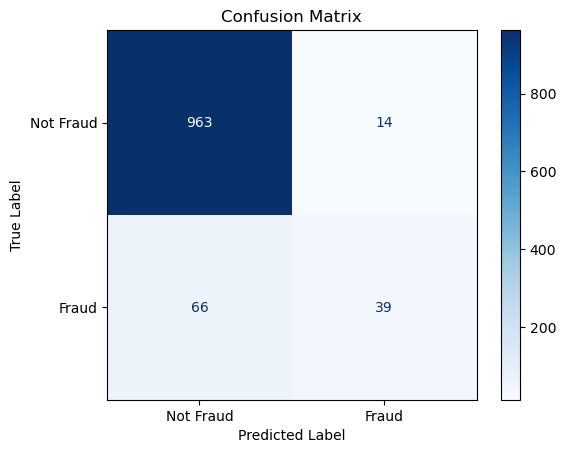

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

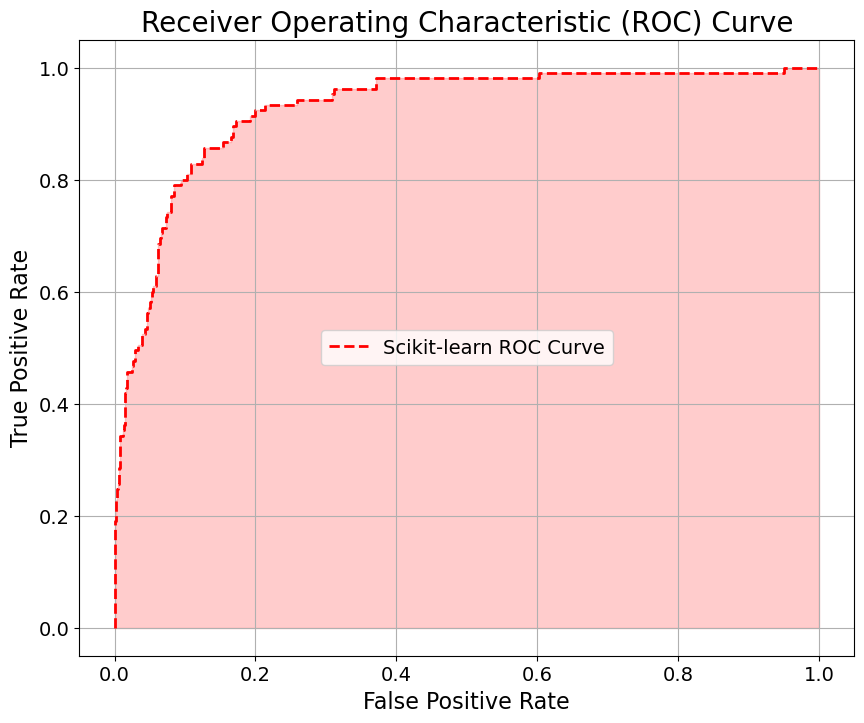

In [23]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.fill_between(fpr, tpr, alpha=0.2, color='red')
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [49]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.9270946044743382)

# Applying cross validation

In [50]:
from sklearn.model_selection import cross_val_score

# Define Logistic Regression model
model = LogisticRegression(max_iter=10000)  # Increase max_iter for convergence

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean auc_roc: {cv_scores.mean():.4f}")


Cross-validation scores: [0.95074737 0.94557988 0.91093146 0.92633805 0.93485394]
Mean auc_roc: 0.9337


## Hyperparameter Tuning Using `GridSearchCV`

Checking for the best paramters that will gives the best result in the scoring parameter

In [51]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 & L2
}

# Define logistic regression model
logreg = LogisticRegression(max_iter=10000)

# Perform GridSearchCV optimizing for roc_auc
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display best parameters and roc_auc score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best roc_auc Score: {grid_search.best_score_:.4f}")


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best roc_auc Score: 0.9393


In [52]:
from sklearn.metrics import classification_report

# Get the best trained model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate performance
report = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
print(report)


              precision    recall  f1-score   support

   Not Fraud       0.93      0.99      0.96       977
       Fraud       0.79      0.31      0.45       105

    accuracy                           0.93      1082
   macro avg       0.86      0.65      0.70      1082
weighted avg       0.92      0.93      0.91      1082



In [53]:
cm = confusion_matrix(y_test, y_pred)

print("confusion Matrix after GridSearch only:\n",cm)

confusion Matrix after GridSearch only:
 [[968   9]
 [ 72  33]]


# <center>SMOTE

smote model will run from scratch, not over someting else (final_df is the dataframe with all the data together)

In [54]:
# Checks how the data looks like, before applying a new concept (SMOTE)
final_df.head()

,Provider,IPReimbursmentTotal,OPReimbursmentTotal,IPClaimDurationSum,IPClaimDurationCount,OPClaimDurationSum,OPClaimDurationCount,PotentialFraud
0,PRV51001,97000.0,7640.0,25.0,5.0,11.0,20.0,0
1,PRV51003,573000.0,32670.0,320.0,62.0,165.0,70.0,1
2,PRV51004,0.0,52170.0,0.0,0.0,213.0,149.0,0
3,PRV51005,0.0,280910.0,0.0,0.0,1268.0,1165.0,1
4,PRV51007,19000.0,14710.0,16.0,3.0,53.0,69.0,0


In [55]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = final_df.drop(columns=['Provider','PotentialFraud'])
y = final_df['PotentialFraud']

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())


Before SMOTE: PotentialFraud
0    3923
1     405
Name: count, dtype: int64
After SMOTE: PotentialFraud
0    3923
1    3923
Name: count, dtype: int64


/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [56]:
model_after_smote = LogisticRegression(max_iter=10000)
model_after_smote.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=10000)

In [57]:
from sklearn.metrics import classification_report

# Predict on the test set (original imbalanced data)
y_pred = model_after_smote.predict(X_test)
y_proba = model_after_smote.predict_proba(X_test)[:, 1] # predict probabilities, what's closer to 0 or 1.


In [58]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[881 100]
 [ 17  84]]


In [59]:
# cm = confusion_matrix(y_test, y_pred)
# print('Confusion Matrix smote:\n', cm)

# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.89
Precision: 0.46
Recall: 0.83
F1 Score: 0.59


### <center>SMOTE AUC_ROC score:

In [60]:
from sklearn.metrics import roc_auc_score

y_proba = model_after_smote.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.9561


# <center>Grid Search CV
<center>This comes after the smote, so I run the grid search over the smote results

In [61]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']
}

# Use GridSearchCV to optimize for recall
grid_search = GridSearchCV(model_after_smote, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}


In [62]:
from sklearn.metrics import roc_auc_score

y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (fraud)
auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC Score for the GridSearchCV over the SMOTE: {auc_score:.4f}")


ROC-AUC Score for the GridSearchCV over the SMOTE: 0.9536


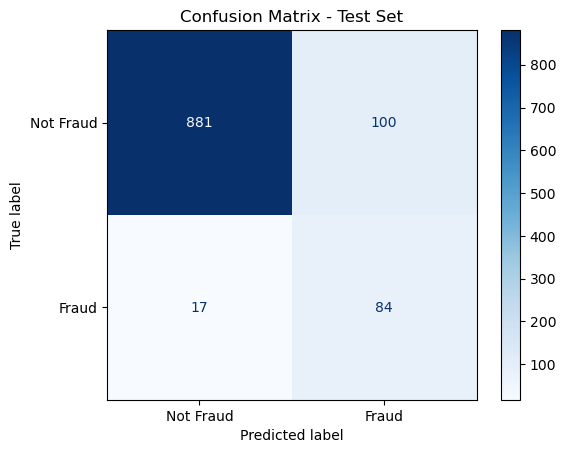

In [63]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()


In [64]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[881 100]
 [ 17  84]]


In [65]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
print('Confusion Matrix after all:\n')
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Confusion Matrix after all:

Accuracy: 0.89
Precision: 0.46
Recall: 0.83
F1 Score: 0.59
